# Importamos librerías para simular un circuito

In [1]:
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import display, HTML #Conf 1
import cufflinks as cf
init_notebook_mode(connected=True) #Conf 2
cf.go_offline() # Conf 2
#cf.set_config_file(offline=True) Conf 1
%matplotlib inline

logger = Logging.setup_logging()

## Empezamos definiendo los elementos del circuito
A continuación se muestra como se deben introducir los elementos:

- Resistencia --> circuito.R(«Nombre», «Polo positivo», «Polo negativo», «Resistencia»)

- Fuente de corriente --> circuito.I(«Nombre», «Polo negativo», «Polo positivo», «Corriente»)

- Fuente de Tensión --> circuito.V(«Nombre», «Polo positivo», «Polo negativo», «Tensión»)

- Fuente de Tensión controlada por tensión
    \--> circuit.VCVS(«Nombre», «OUT positivo», «OUT negativo», «IN positivo», «IN negativo», «ganancia») circuito.E para llamar
    
- Fuente de Tensión controlada por corriente
    \--> circuito.H ó circuit.CCVS(«Nombre», «OUT positivo», «OUT negativo», «Dispositivo source», «ganancia»)
    
- Fuente de corriente controlada por corriente
    \--> circuito.F ó circuit.CCCS(«Nombre», «OUT negativo», «OUT positivo», «Dispositivo source», «ganancia»)
    
- Fuente de corriente controlada por tensión
    \--> circuit.VCCS(«Nombre», «OUT negativo», «OUT positivo», «IN positivo», «IN negativo», «ganancia») circuito.G para llamar
    
Tenga en cuenta que el flujo de la corriente en las fuentes de corriente es del primer polo al segundo, es por eso que invertí los polos en este "manual".

In [2]:
circuit = Circuit('Fuentes Controladas y técnicas algorítmicas')

GND = circuit.gnd

circuit.R(1, 1, 4, 10@u_Ω)
circuit.R(2, 2, GND, 20@u_Ω)
circuit.R(3, 3, 2, 50@u_Ω)
circuit.I(1, GND, 1, 3@u_A)
circuit.I(2, GND, 3, 5@u_A)
circuit.VCVS(1, 4, 3, 2, GND, 3)
# circuit.V('aux', 3, 'x', 0)
# circuit.CCCS(1, 1, 2, 'R3', 2)

VoltageControlledVoltageSource E1

<img src='Circuito.png' width="400" height="400">

In [3]:
elementos = list(circuit.element_names)
r = []
for i in elementos:
    if 'R' in i:
        r.append(i)

In [4]:
# Rnodos = {}
# for i in r:
#     Rnodos[i] = circuit[i].node_names

## Añadimos voltímetros o amperímetros antes de simularlo

In [5]:
for i in r:
    circuit[i].plus.add_current_probe(circuit)

### Las fuentes controladas de corriente se pondrán aquí
Ponemos las fuentes de corriente luego de poner los respectivos instrumentos de medición, con el fin de usar la lectura hecha por el instrumento de medición, así nos evitamos la colocación de una fuente de tensión, con valor 0.

In [6]:
circuit.CCCS(1, 1, 2, 'VR3_plus', 2)

CurrentControlledCurrentSource F1

## Simulamos

In [7]:
simulador = circuit.simulator(temperature=25, nominal_temperature=25)
analisis = simulador.operating_point()

2022-10-12 10:07:07,496 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 37


# Extracción y procesamiento de la información 

## A continuación vamos a almacenar los datos en diferentes diccionarios

In [8]:
corrientes = {}
tensiones = {}
for node in analisis.nodes.values():
    tensiones[str(node)] = round(float(node),2)
    print(f'{str(node)}: {round(float(node),2)} V')
    
for branch in analisis.branches.values():
    corrientes[str(branch)] = round(float(branch),2)
    print(f'{str(branch)}: {round(float(branch),2)} A')

3: 293.33 V
1: 750.0 V
2: 160.0 V
r3_plus: 293.33 V
r2_plus: 160.0 V
4: 773.33 V
r1_plus: 750.0 V
vr1_plus: -2.33 A
vr2_plus: 8.0 A
e1: -2.33 A
vr3_plus: 2.67 A


- Los número solos son los nodos, 
- los r{}\_plus son las terminales positivas de las resistencias
- e1 es la fuente de tensión controlada por tensión
- vprueba es la fuente de tensión de 0 voltios que se añade como source para la fuente de corriente controlada por corriente
- x es un nodo que se crea al añadir la fuente de 0 V

## Ahora vamos a clasificar cada tipo de elemento en listas
así: 
- cs será para las fuentes de corriente.
- cvs será para las fuentes de tensión controladas.
- ccs será para las fuentes de corriente controladas.
- vs será para las fuentes de tensión.
- r para las resistencias.
- Y med para los instrumentos de medida

In [9]:
cs = []
cvs = []
ccs = []
vs = []
# r = []
med = []
for i in list(circuit.element_names):
    if 'I' in i:
        cs.append(i)
    elif 'V' in i and not 'R' in i:
        vs.append(i)
    # elif 'R' in i and not 'plus' in i:
        # r.append(i)
    elif 'aux' in i or 'E' in i or 'H' in i:
        cvs.append(i)
    elif 'F' in i or 'G' in i:
        ccs.append(i)
    else:
        med.append(i)

## Tensiones y corrientes de fuentes
Las tensiones y corrientes de los elementos están en las variables tensiones y corrientes en forma de diccionarios, pero las tensiones y corrientes de las diferentes fuentes no están en ninguna variable, por eso crearemos las variables en forma de diccionario Fcorriente y Ftension, con el fin de hacer más accesibles estos valores eléctricos de cada fuente

In [10]:
Fcorriente = {}
Ftension = {}
for i in cs:
    if 'I' in i:
        Fcorriente[i] = float(circuit[i].dc_value)
        
for i in vs:
    if 'V' in i:
        Ftension[i] = float(circuit[i].dc_value)

Ahora podemos acceder al valor de las fuentes de corriente o tensión invocándolos desde un diccionario

In [11]:
Fcorriente

{'I1': 3.0, 'I2': 5.0}

In [12]:
Ftension

{}

## Valores de resistencias

In [13]:
circuit.R1.plus

Pin plus of R1 on node R1_plus

In [14]:
Tresistencias = {}
for i in r:
    corriente = 'v'+i.lower()+'_plus'
    Tresistencias[i] = [corrientes[corriente]*circuit[i].resistance.value, corrientes[corriente], circuit[i].resistance.value]

In [15]:
Tresistencias

{'R1': [-23.3, -2.33, 10], 'R2': [160.0, 8.0, 20], 'R3': [133.5, 2.67, 50]}

## Valores de fuentes

In [16]:
Tfuentes = {}

# Para construir el diagrama AVOW necesitamos:
- Construir un data frame para graficarlo, por ejemplo tenemos este:

In [17]:
df2 = pd.DataFrame({'x':['p','q','r'], 'y':[1,2,3]})
df2

,x,y
0,p,1
1,q,2
2,r,3


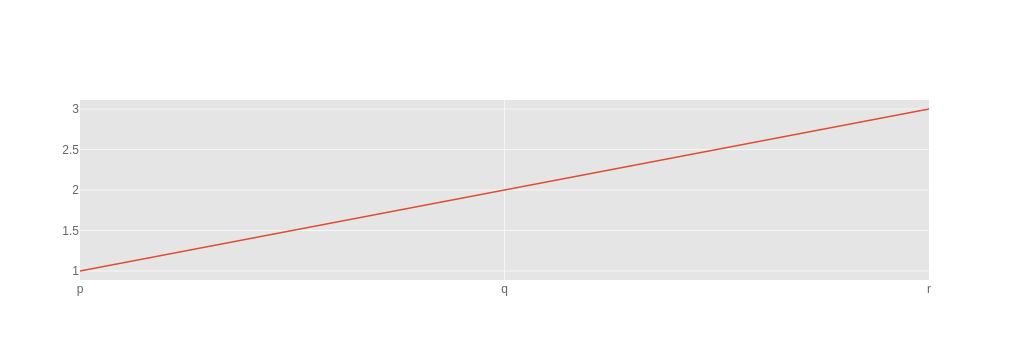

In [18]:
# Al graficarlo nos queda:
df2.iplot(kind='scatter',x='x',y='y')

## ¿A qué elementos se puede aplicar un mismo diagrama?
El diagrama AVOW se puede aplicar a elementos con tensión igual o corriente igual, para la mayoría de casos quiere decir que deben haber tantos gráficos diferentes, como corrientes puedan existir, ya que es más común encontrar corrientes iguales, debido a que cada malla comparte una, pero en la intersección de cada par de mallas hay otra corriente.

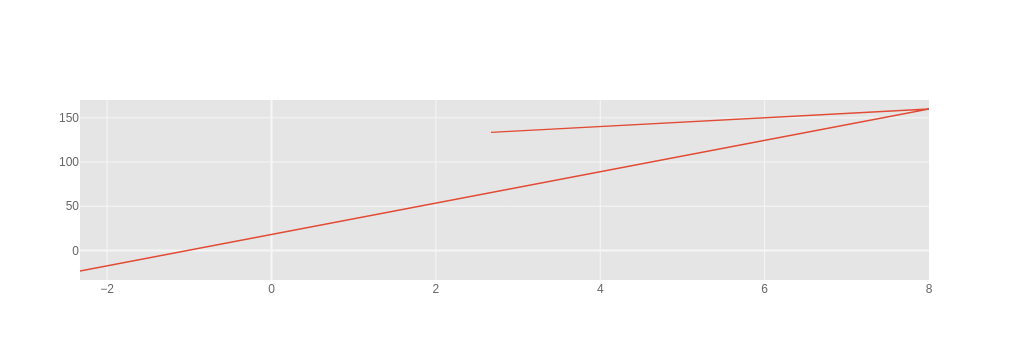

,V,I,R
R1,-23.3,-2.33,10.0
R2,160.0,8.00,20.0
R3,133.5,2.67,50.0


In [38]:
df2 = pd.DataFrame(Tresistencias, index=['V','I','R'])
df3 = df2.transpose()
df3.iplot(x='I', y='V')
df3

# Desde aquí para abajo son pruebas de funcionamiento

In [20]:
circuit['E1'].voltage_gain

3

In [21]:
circuit['F1'].current_gain

2

In [22]:
circuit.E1.pins

[Pin output_plus of E1 on node 4,
 Pin output_minus of E1 on node 3,
 Pin input_plus of E1 on node 2,
 Pin input_minus of E1 on node 0]

In [23]:
list(circuit.element_names)

['R1', 'R2', 'R3', 'I1', 'I2', 'E1', 'VR1_plus', 'VR2_plus', 'VR3_plus', 'F1']

In [24]:
print(
    'Vamos a clasificarlos:\n'
    f'Las resistencias son: {r}\n'
    f'Las fuentes de tensión son: {vs}\n'
    f'Las fuentes de corriente son: {cs}\n'
    f'Las fuentes controladas de corriente son: {ccs}\n'
    f'Las fuentes controladas de tensión son: {cvs}\n'
    f'Y por último los aparatos de medición son: {med}'
)

Vamos a clasificarlos:
Las resistencias son: ['R1', 'R2', 'R3']
Las fuentes de tensión son: []
Las fuentes de corriente son: ['I1', 'I2']
Las fuentes controladas de corriente son: ['F1']
Las fuentes controladas de tensión son: ['E1']
Y por último los aparatos de medición son: ['R1', 'R2', 'R3', 'VR1_plus', 'VR2_plus', 'VR3_plus']


In [43]:
for i in tensiones:
    

3
1
2
r3_plus
r2_plus
4
r1_plus


In [26]:
corrientes

{'vr1_plus': -2.33, 'vr2_plus': 8.0, 'e1': -2.33, 'vr3_plus': 2.67}

In [42]:
df = pd.DataFrame(np.random.randn(100, 4), columns = ['A','B','C','D'])
df.head()

,A,B,C,D
0,-0.711737,0.048468,-1.079485,-0.173076
1,1.194585,1.457260,-0.247099,1.062204
2,-0.321673,-0.200833,-0.524148,-0.387766
3,-0.658551,-0.370010,1.724110,1.644601
4,0.104434,-0.445898,-0.959876,-0.808378


In [28]:
# todo['R1'] = [corrientes['vr1_plus']*Vresistencia['R1'], corrientes['vr1_plus'], Vresistencia['R1']]

In [29]:
r

['R1', 'R2', 'R3']